In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
df = pd.read_excel("/content/drive/MyDrive/Healthcare_premium_pred/datasets/premiums_rest.xlsx")
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610


In [3]:
df.shape

(29904, 13)

In [4]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount'],
      dtype='object')

In [5]:
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.head(1)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053


### Handle NA values

In [6]:
df.isnull().sum()

,0
age,0
gender,0
region,0
marital_status,0
number_of_dependants,0
bmi_category,0
smoking_status,9
employment_status,1
income_level,9
income_lakhs,0


In [7]:
df.dropna(inplace=True)
df.isnull().sum()

,0
age,0
gender,0
region,0
marital_status,0
number_of_dependants,0
bmi_category,0
smoking_status,0
employment_status,0
income_level,0
income_lakhs,0


### Handle Duplicate Values

In [8]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [9]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29886.000000,29886.000000,29886.000000,29886.000000
mean,43.396105,2.379910,23.364184,20892.303821
std,13.412657,1.431201,24.740339,6936.813440
min,26.000000,-3.000000,1.000000,3625.000000
25%,34.000000,1.000000,7.000000,15697.250000
50%,42.000000,3.000000,17.000000,20489.000000
75%,52.000000,3.000000,32.000000,26360.000000
max,356.000000,5.000000,930.000000,43471.000000


In [10]:
df[df.number_of_dependants<0]['number_of_dependants'].unique()

array([-1, -3])

In [11]:
df['number_of_dependants'] = abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

,number_of_dependants
count,29886.000000
mean,2.385933
std,1.421137
min,0.000000
25%,1.000000
50%,3.000000
75%,3.000000
max,5.000000


### Outlier Detection

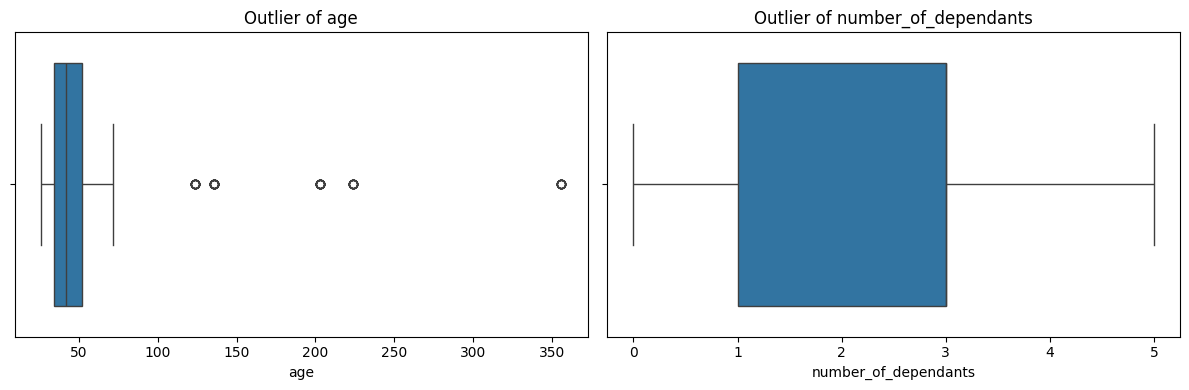

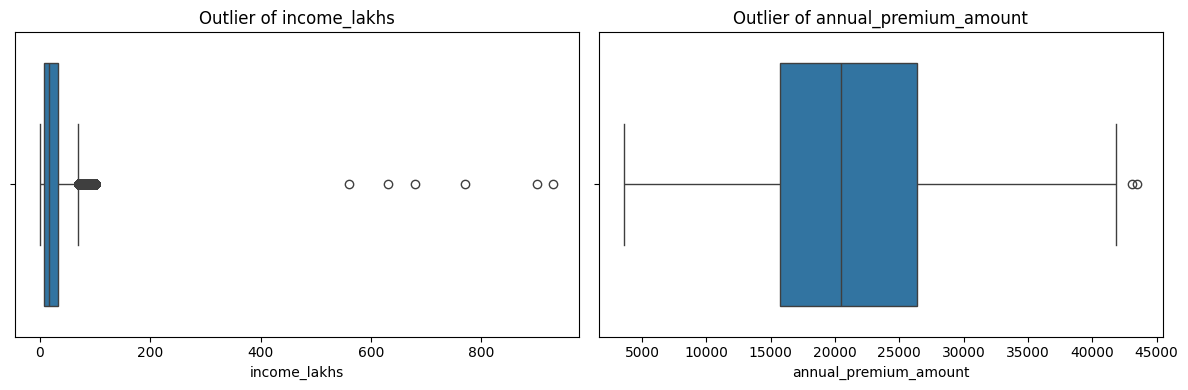

In [12]:
numeric_cols = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]

for i in range(0, len(numeric_cols), 2):
    plt.figure(figsize=(12, 4))

    # First plot
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df[numeric_cols[i]])
    plt.title(f"Outlier of {numeric_cols[i]}")

    # Second plot (if exists)
    if i + 1 < len(numeric_cols):
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[numeric_cols[i + 1]])
        plt.title(f"Outlier of {numeric_cols[i + 1]}")

    plt.tight_layout()
    plt.show()


In [13]:
df[df.age>100]['age'].unique()

array([224, 124, 136, 203, 356])

In [14]:
df1 = df[df.age<=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29828.000000,29828.000000,29828.000000,29828.000000
mean,43.095380,2.387790,23.371530,20901.900563
std,11.041991,1.420641,24.751262,6928.457636
min,26.000000,0.000000,1.000000,6538.000000
25%,34.000000,1.000000,7.000000,15706.000000
50%,42.000000,3.000000,17.000000,20496.000000
75%,52.000000,3.000000,32.000000,26361.000000
max,72.000000,5.000000,930.000000,43471.000000


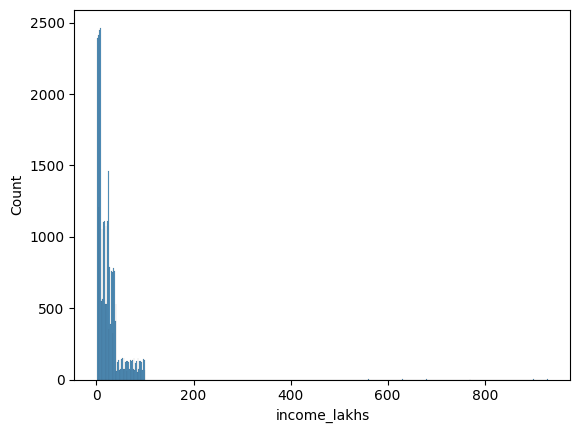

In [15]:
sns.histplot(df1['income_lakhs'])
plt.show()

In [16]:
def get_iqr_bounds(col):
  Q1, Q3 = col.quantile([0.25, 0.75])
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  return lower_bound, upper_bound

In [17]:
get_iqr_bounds(df1['income_lakhs'])

(-30.5, 69.5)

In [18]:
quantile_threshold = df1.income_lakhs.quantile(0.999)
quantile_threshold

np.float64(100.0)

In [19]:
df2 = df1[df1.income_lakhs<=quantile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29822.000000,29822.000000,29822.000000,29822.000000
mean,43.094896,2.387734,23.226343,20900.689223
std,11.042430,1.420644,22.455408,6928.192115
min,26.000000,0.000000,1.000000,6538.000000
25%,34.000000,1.000000,7.000000,15705.250000
50%,42.000000,3.000000,17.000000,20495.500000
75%,52.000000,3.000000,32.000000,26360.000000
max,72.000000,5.000000,100.000000,43471.000000


### Dataset skeww check

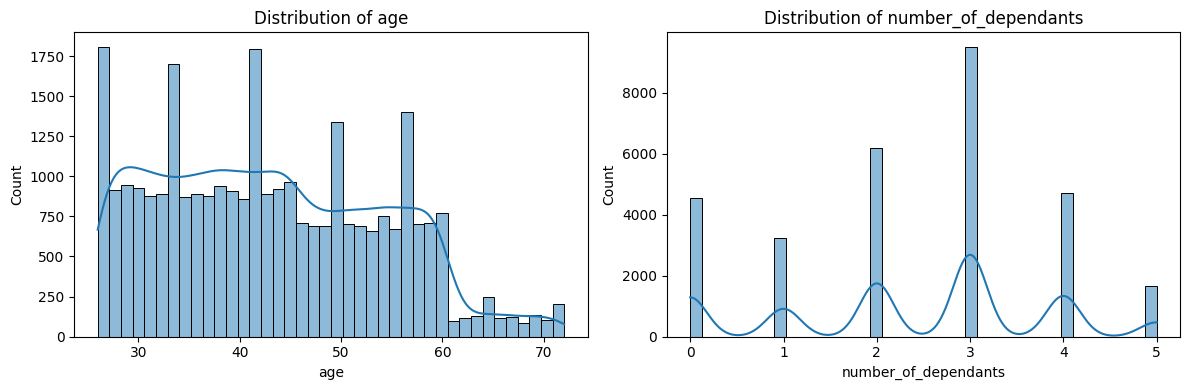

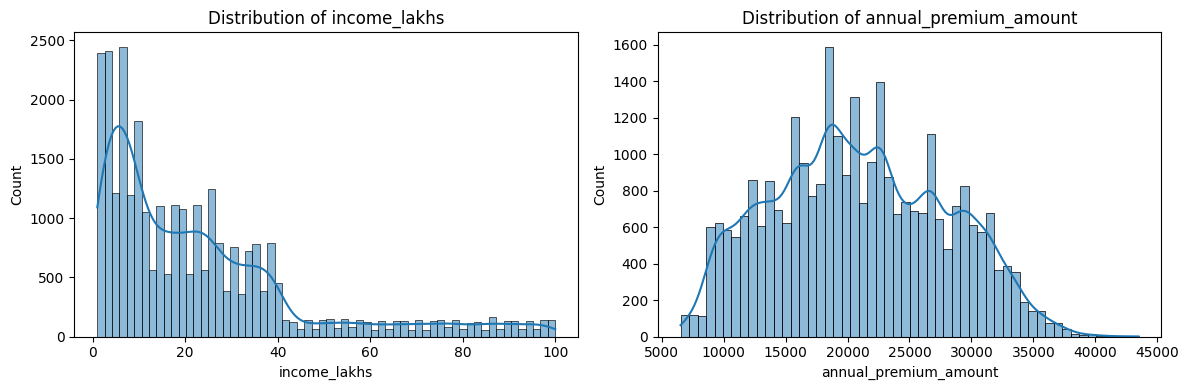

In [20]:
numeric_cols = [col for col in df2.columns if df2[col].dtype in ['int64', 'float64']]

# Loop through 2 at a time
for i in range(0, len(numeric_cols), 2):
    plt.figure(figsize=(12, 4))

    # First histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df2[numeric_cols[i]], kde=True)
    plt.title(f"Distribution of {numeric_cols[i]}")

    # Second histogram (if it exists)
    if i + 1 < len(numeric_cols):
        plt.subplot(1, 2, 2)
        sns.histplot(df2[numeric_cols[i + 1]], kde=True)
        plt.title(f"Distribution of {numeric_cols[i + 1]}")

    plt.tight_layout()
    plt.show()

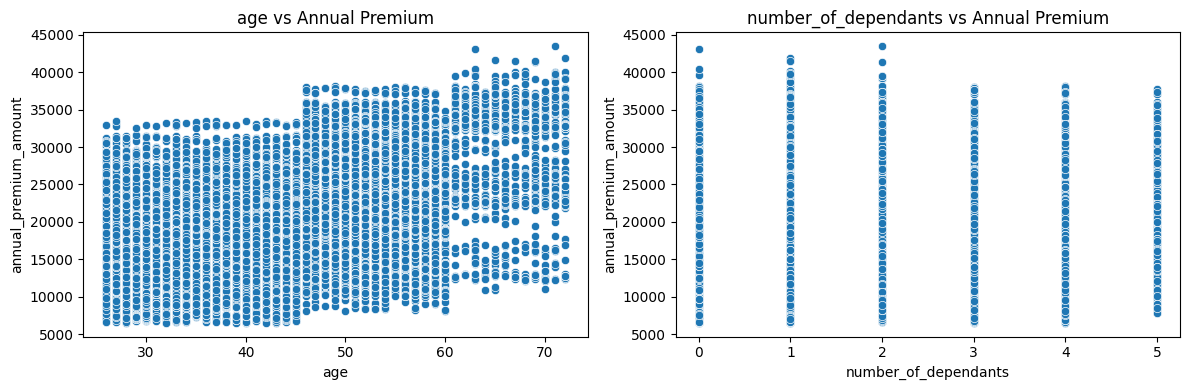

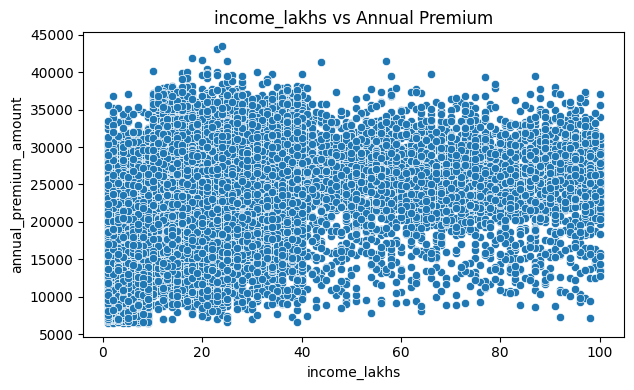

In [21]:
# Get all numeric columns except 'annual_premium_amount'
numeric_cols = [col for col in df2.columns if df2[col].dtype in ['int64', 'float64'] and col != 'annual_premium_amount']

# Loop and plot
for i in range(0, len(numeric_cols), 2):
    plt.figure(figsize=(12, 4))

    # First plot
    plt.subplot(1, 2, 1)
    sns.scatterplot(data=df2, x=numeric_cols[i], y='annual_premium_amount')
    plt.title(f"{numeric_cols[i]} vs Annual Premium")

    # Second plot (if exists)
    if i + 1 < len(numeric_cols):
        plt.subplot(1, 2, 2)
        sns.scatterplot(data=df2, x=numeric_cols[i + 1], y='annual_premium_amount')
        plt.title(f"{numeric_cols[i + 1]} vs Annual Premium")

    plt.tight_layout()
    plt.show()


In [22]:
df2.head(1)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053


In [23]:
cat_col = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status', 'income_level', 'medical_history', 'insurance_plan']
for col in cat_col:
  print(col,":", df2[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Does Not Smoke' 'Not Smoking'
 'Smoking=0']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


### Dirty Read values in smoking_status...

In [24]:
df2['smoking_status'] = df2['smoking_status'].replace({
    'Smoking=0': 'No Smoking',
    'Does Not Smoke': 'No Smoking',
    'Not Smoking': 'No Smoking'
})
df2['smoking_status'].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [25]:
pct_count = df2['gender'].value_counts(normalize=True)
pct_count

,proportion
gender,
Male,0.549125
Female,0.450875


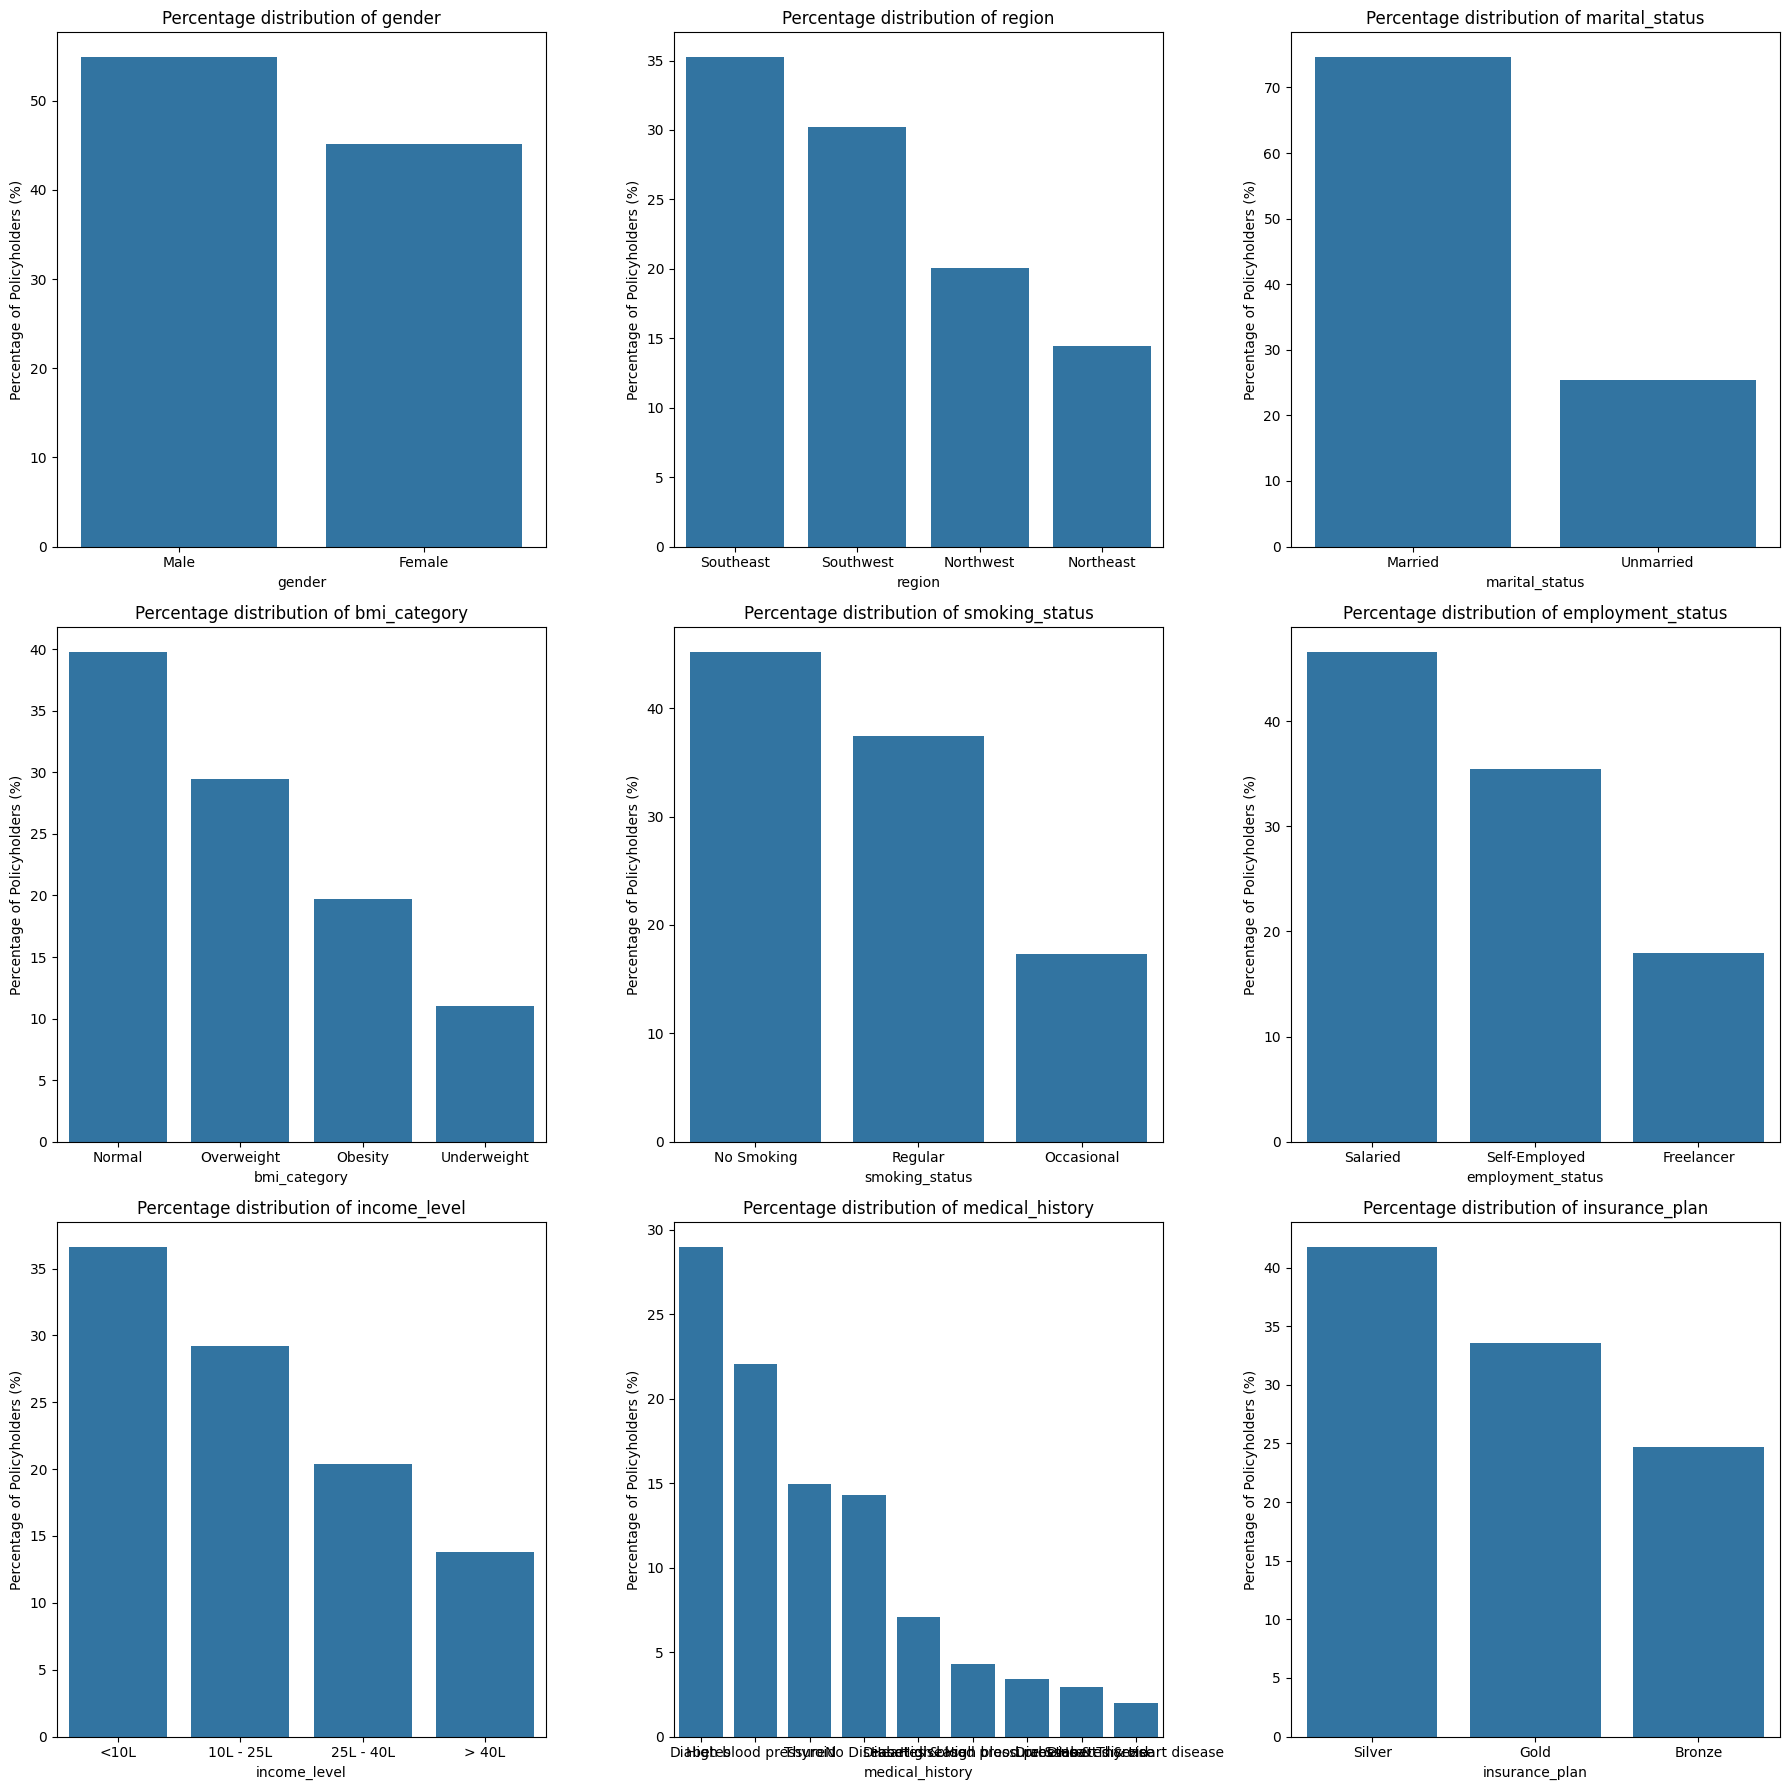

In [26]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
axes = axes.flatten()

for ax, column in zip(axes, cat_col):
  # Calculate the percentage distribution of each category.
  category_counts = df2[column].value_counts(normalize=True) * 100
  sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
  ax.set_title(f'Percentage distribution of {column}')
  ax.set_ylabel('Percentage of Policyholders (%)')
  ax.set_xlabel(column)

plt.tight_layout()
plt.show()


## Income vs Plan. --> Bivariate analysis

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L          799  3554    4354
25L - 40L          301  2631    3142
<10L              6054   527    4341
> 40L              214  3287     618


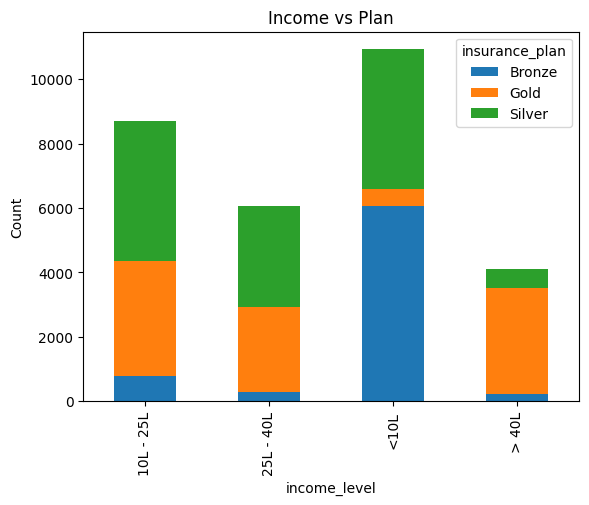

In [27]:
crosstab = pd.crosstab(df2['income_level'], df2['insurance_plan'])
print(crosstab)

crosstab.plot(kind='bar', stacked=True)
plt.title("Income vs Plan")
plt.ylabel('Count')
plt.show()

<Axes: xlabel='insurance_plan', ylabel='income_level'>

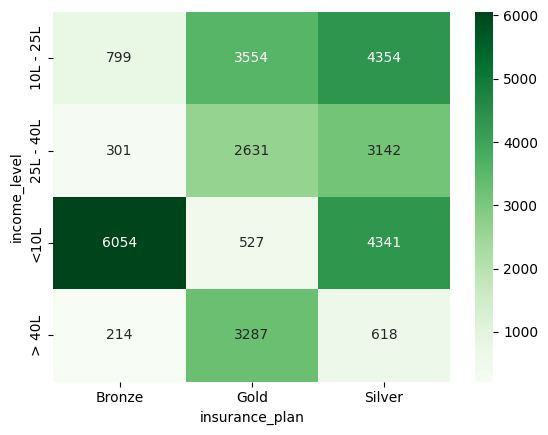

In [28]:
sns.heatmap(crosstab, annot=True, fmt='d', cmap='Greens')

# <h1 style="color:blue;">Feature Engineering</h1>

In [29]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339


In [30]:
df2.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [31]:
df2[['disease1', 'disease2']] = df2['medical_history'].str.split(' & ', expand=True).apply(lambda x: x.str.lower())
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,None
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,None
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,None


In [32]:
df2.sample(5)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
13334,55,Female,Northwest,Married,4,Normal,No Smoking,Self-Employed,25L - 40L,37,No Disease,Silver,16861,no disease,None
5834,36,Male,Southeast,Married,4,Underweight,Regular,Salaried,25L - 40L,37,Diabetes & Thyroid,Silver,20523,diabetes,thyroid
7872,34,Male,Northeast,Married,3,Overweight,No Smoking,Self-Employed,10L - 25L,22,Thyroid,Silver,17393,thyroid,None
13370,40,Female,Southeast,Married,3,Normal,Regular,Freelancer,> 40L,69,Diabetes,Bronze,11747,diabetes,None
23100,50,Female,Southeast,Married,3,Obesity,No Smoking,Self-Employed,<10L,9,Thyroid,Silver,22187,thyroid,None


# Working on risk factor according to the disease

In [33]:
risk_score = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure": 6,
    "thyroid": 5,
    "no disease": 0,
    "none": 0
}


In [34]:
df2['disease1'].fillna('none', inplace=True)
df2['disease2'].fillna('none', inplace=True)
df2['total_risk_score'] = 0


for disease in ['disease1', 'disease2']:
  df2['total_risk_score'] += df2[disease].map(risk_score)

max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.head(3)

/tmp/ipython-input-2959938099.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['disease1'].fillna('none', inplace=True)
/tmp/ipython-input-2959938099.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,none,6,0.428571


In [35]:
df2.sample(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
16872,47,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,> 40L,75,Heart disease,Gold,32309,heart disease,none,8,0.571429
9668,56,Male,Northwest,Married,2,Normal,Occasional,Salaried,10L - 25L,23,High blood pressure,Gold,27970,high blood pressure,none,6,0.428571
7340,32,Male,Southwest,Married,3,Overweight,No Smoking,Salaried,25L - 40L,28,Diabetes,Silver,17972,diabetes,none,6,0.428571


### Encoding Technique

In [36]:
df2.insurance_plan.unique()

array(['Bronze', 'Silver', 'Gold'], dtype=object)

In [37]:
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})
df2.insurance_plan.unique()

array([1, 2, 3])

In [38]:
df2['income_level'].unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L'], dtype=object)

In [39]:
df2['income_level'] = df2['income_level'].map({'<10L': 1, '10L - 25L': 2, '> 40L': 4, '25L - 40L': 3})

In [40]:
df2['income_level'].unique()

array([1, 2, 4, 3])

In [41]:
df2.sample(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
28875,54,Male,Southeast,Unmarried,1,Overweight,Regular,Freelancer,1,8,Thyroid,2,23250,thyroid,none,5,0.357143
8551,30,Male,Southwest,Married,4,Normal,Regular,Self-Employed,2,11,No Disease,2,16801,no disease,none,0,0.000000
4562,39,Male,Southeast,Unmarried,1,Normal,No Smoking,Self-Employed,3,39,Diabetes,1,9503,diabetes,none,6,0.428571


In [42]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,diabetes,none,6,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,diabetes,none,6,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,6,...,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,No Disease,3,20303,no disease,none,0,...,1,0,0,0,0,0,0,0,1,0
4,56,3,2,14,Diabetes,1,15610,diabetes,none,6,...,0,0,0,1,0,0,1,0,0,1


In [43]:
df4 = df3.drop(['medical_history', 'disease1', 'disease2', 'total_risk_score'], axis=1)
df4.head(3)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1


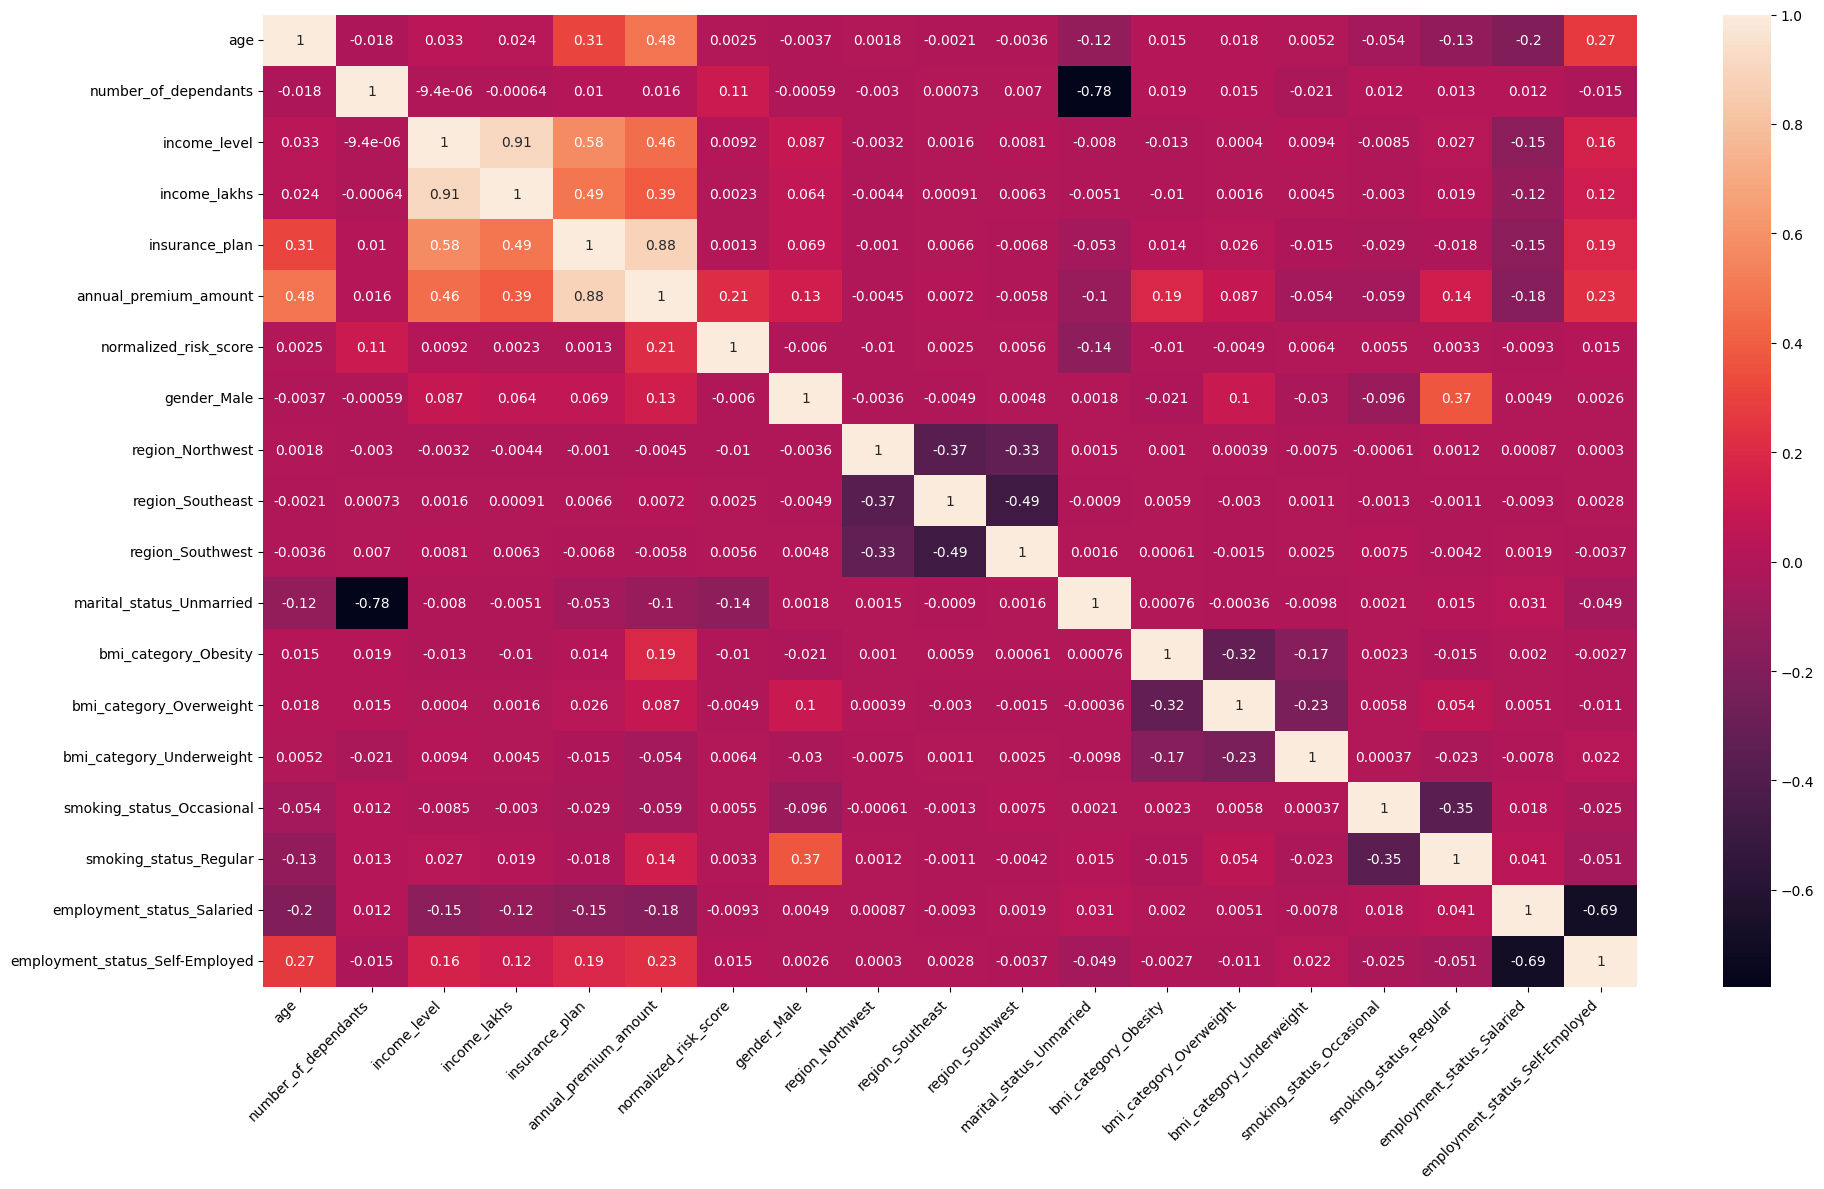

In [44]:
cm = df4.corr() # Call the corr() method to get the correlation matrix

plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Scaling ->

In [45]:
df4.head(1)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0


In [46]:
X = df4.drop('annual_premium_amount', axis='columns')
y = df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler
cols_to_scale = ['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000
mean,0.371628,0.477547,0.371225,0.224509,0.544112,0.426373,0.549125,0.200691,0.352693,0.301992,0.253336,0.196835,0.295051,0.110087,0.173228,0.374656,0.466132,0.354269
std,0.240053,0.284129,0.351111,0.226822,0.379009,0.240084,0.497589,0.400524,0.477816,0.459129,0.434929,0.397613,0.456073,0.313003,0.378450,0.484042,0.498860,0.478299
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.173913,0.200000,0.000000,0.060606,0.500000,0.357143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.347826,0.600000,0.333333,0.161616,0.500000,0.428571,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.565217,0.600000,0.666667,0.313131,1.000000,0.428571,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [47]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
  vif_df = pd.DataFrame()
  vif_df['Column'] = data.columns
  vif_df['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
  return vif_df

In [48]:
calculate_vif(X)

,Column,VIF
0,age,3.921783
1,number_of_dependants,6.278938
2,income_level,13.890522
3,income_lakhs,11.185596
4,insurance_plan,5.271297
5,normalized_risk_score,3.810619
6,gender_Male,2.599098
7,region_Northwest,2.123965
8,region_Southeast,2.980842
9,region_Southwest,2.710097


In [49]:
calculate_vif(X.drop('income_level', axis='columns'))

,Column,VIF
0,age,3.863055
1,number_of_dependants,6.278147
2,income_lakhs,2.678102
3,insurance_plan,4.574625
4,normalized_risk_score,3.808345
5,gender_Male,2.591439
6,region_Northwest,2.123277
7,region_Southeast,2.979899
8,region_Southwest,2.708641
9,marital_status_Unmarried,2.345757


In [50]:
X_reduced = X.drop('income_level', axis='columns')
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.0,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.065217,0.4,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.500000,0.4,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.086957,0.6,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.652174,0.6,0.131313,0.0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


# **Model Training ->**

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=10)

print("X train:", X_train.shape)
print("X test:", X_test.shape)
print("y train:", y_train.shape)
print("y test:", y_test.shape)

X train: (20875, 17)
X test: (8947, 17)
y train: (20875,)
y test: (8947,)




> train_score and test_score both are same, So there is not any case of Model overfitting.



In [52]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
train_score = model_lr.score(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score, test_score

(0.9534163989489616, 0.9538448451629948)

In [53]:
model_lr.coef_

array([ 7016.2393283 , -1311.76470171,  -708.19336921, 14835.98820801,
        6053.6241234 ,    37.55826883,   -55.25087215,   -19.62254288,
         -22.28967559,  -700.32019985,  3926.8127061 ,  1979.45604663,
         612.86623617,   837.3951011 ,  2800.66184334,   -45.49136706,
         243.07842087])

In [54]:
model_lr.intercept_

np.float64(5935.981289344598)

### Finding the Feature Participation among the training

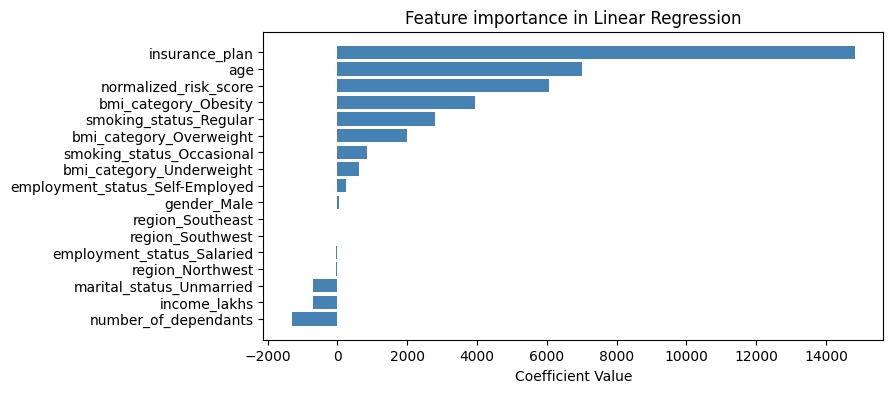

In [55]:
feature_importance = model_lr.coef_

coef_df = pd.DataFrame(feature_importance, index=X_test.columns, columns=['Coefficients'])
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature importance in Linear Regression')
plt.show()

In [56]:
alpha_rng = [1, 0.1, 10.0, 5, 0.01]

for alpha in alpha_rng:
    model_rg = Ridge(alpha=alpha)
    model_rg.fit(X_train, y_train)
    train_score = model_rg.score(X_train, y_train)
    test_score = model_rg.score(X_test, y_test)
    print(f'Training score for alpha {alpha}: {train_score:.2f} | Testing score: {test_score:.2f}')

Training score for alpha 1: 0.95 | Testing score: 0.95
Training score for alpha 0.1: 0.95 | Testing score: 0.95
Training score for alpha 10.0: 0.95 | Testing score: 0.95
Training score for alpha 5: 0.95 | Testing score: 0.95
Training score for alpha 0.01: 0.95 | Testing score: 0.95


In [57]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
train_score = model_xgb.score(X_train, y_train)
test_score = model_xgb.score(X_test, y_test)
train_score, test_score

(0.9986370801925659, 0.9979538321495056)

In [58]:
y_pred = model_xgb.predict(X_test)

mse_lr = mean_squared_error(y_pred, y_test)
rmse_lr = np.sqrt(mse_lr)
print("XGBoost Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

XGBoost Regression ==> MSE:  96814.21875 RMSE:  311.1498332797239


In [59]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}

random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=4)
random_search.fit(X_train, y_train)
random_search.best_score_

np.float64(0.9977717598279318)

In [60]:
random_search.best_params_

{'n_estimators': 40, 'max_depth': 4, 'learning_rate': 0.2}

In [61]:
best_model = random_search.best_estimator_

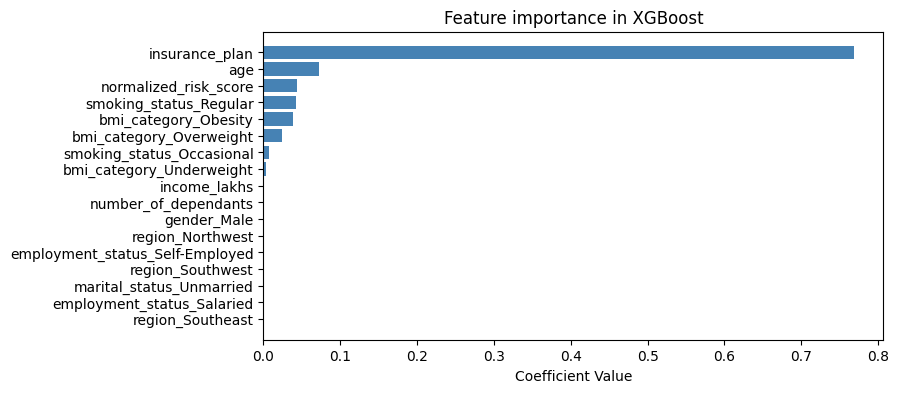

In [62]:
feature_importance = best_model.feature_importances_

coef_df = pd.DataFrame(feature_importance, index=X_test.columns, columns=['Coefficients'])
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature importance in XGBoost')
plt.show()



> XGBoost has given a good accuracy comparison to Linear Regression, but this feature importance is not good as compared to Linear_reg model.



## Error Analysis..

In [63]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = residuals*100/y_test

result_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'diff': residuals,
    'diff_pct': residuals_pct
})

result_df.head()

,actual,predicted,diff,diff_pct
19713,26895,26641.001953,-253.998047,-0.944406
14750,22734,22956.232422,222.232422,0.977533
19932,21198,21504.177734,306.177734,1.444371
29643,9100,9271.687500,171.687500,1.886676
17076,26434,26641.001953,207.001953,0.783090




> We can see here diff_pct for some values is too high, which is a big error.



<Axes: xlabel='diff_pct', ylabel='Count'>

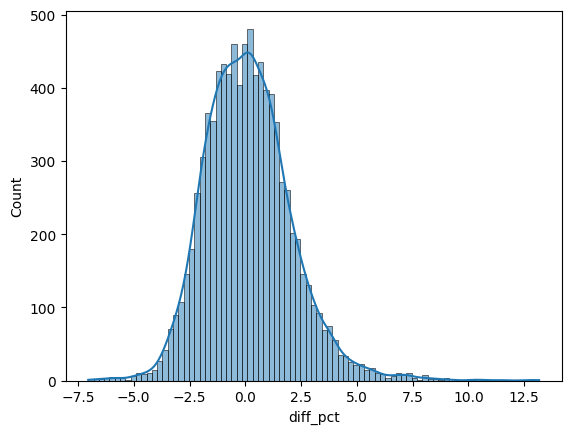

In [64]:
sns.histplot(result_df['diff_pct'], kde=True)

In [65]:
extreme_error_threshold = 10

extreme_result_df = result_df[np.abs(result_df.diff_pct)>extreme_error_threshold]
extreme_result_df.shape

(9, 4)

In [66]:
extreme_result_pct = extreme_result_df.shape[0]*100/result_df.shape[0]
extreme_result_pct

0.10059237733318431

In [67]:
result_df[np.abs(result_df['diff_pct']>50)].sort_values('diff_pct', ascending=False)

,actual,predicted,diff,diff_pct


In [68]:
extreme_result_df.index

Index([7547, 21910, 12189, 8216, 21455, 10741, 6517, 13744, 11019], dtype='int64')

In [69]:
extreme_errors_df = X_test.loc[extreme_result_df.index]
extreme_errors_df.shape

(9, 17)

In [70]:
extreme_errors_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
7547,0.347826,0.2,0.080808,0.0,0.0,1,0,1,0,1,0,0,0,0,0,1,0
21910,0.043478,0.6,0.020202,0.0,0.0,1,0,1,0,0,0,0,0,0,0,0,0
12189,0.043478,0.6,0.060606,0.0,0.0,1,0,0,1,0,0,0,0,0,0,1,0
8216,0.152174,0.4,0.010101,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0
21455,0.239130,0.2,0.080808,0.0,0.0,1,1,0,0,1,0,0,0,0,0,0,0


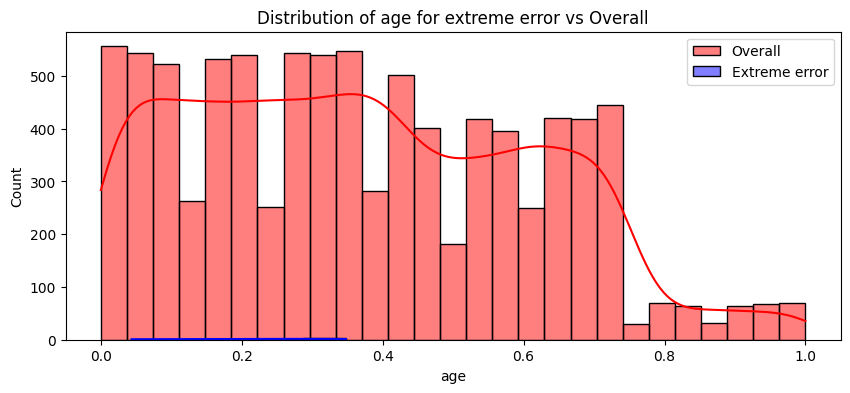

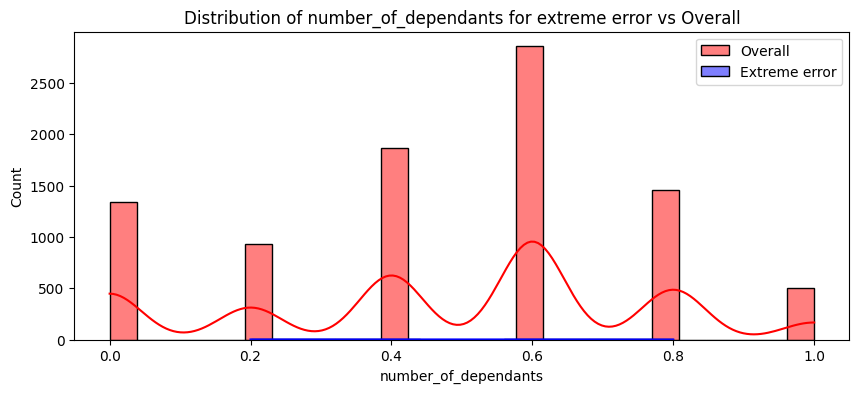

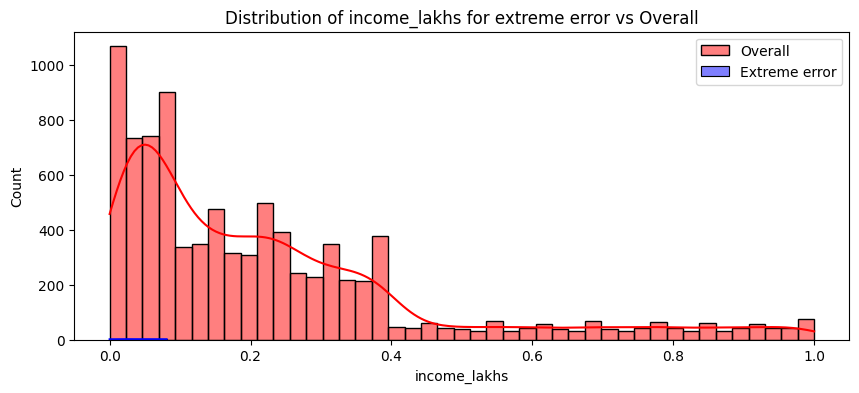

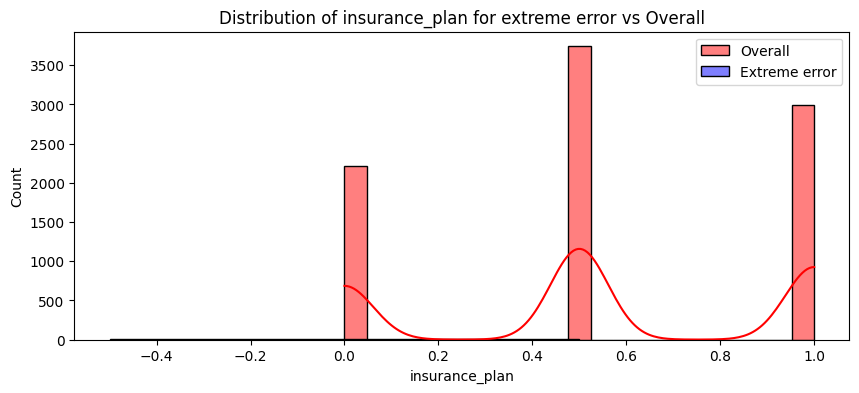

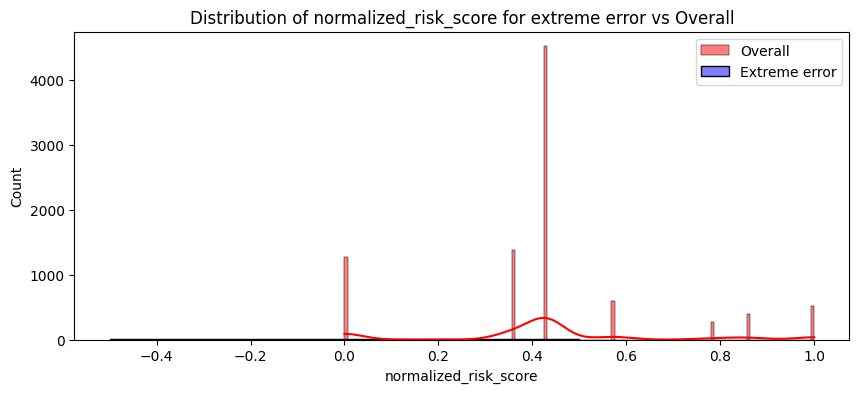

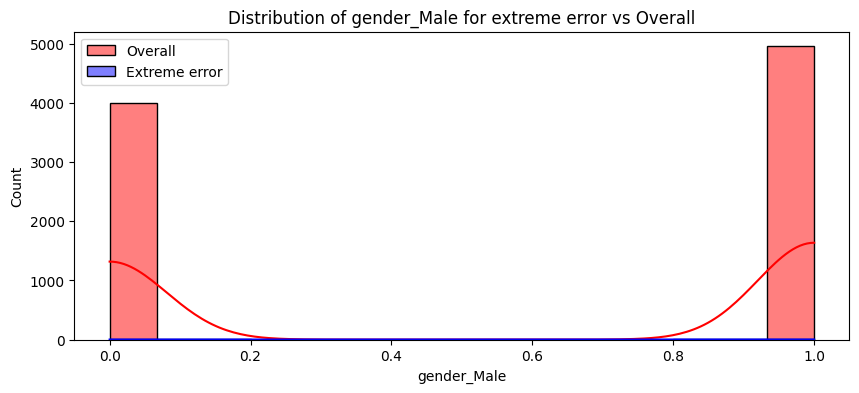

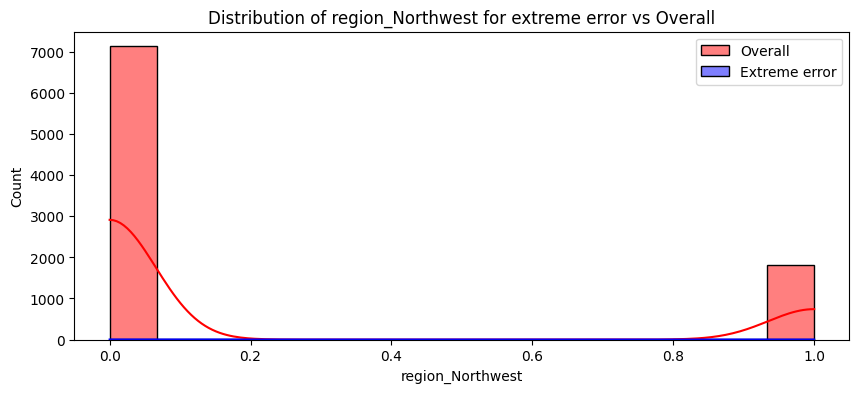

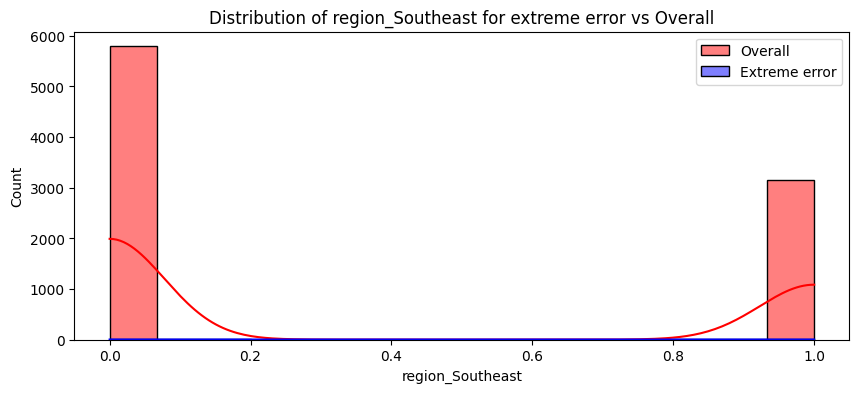

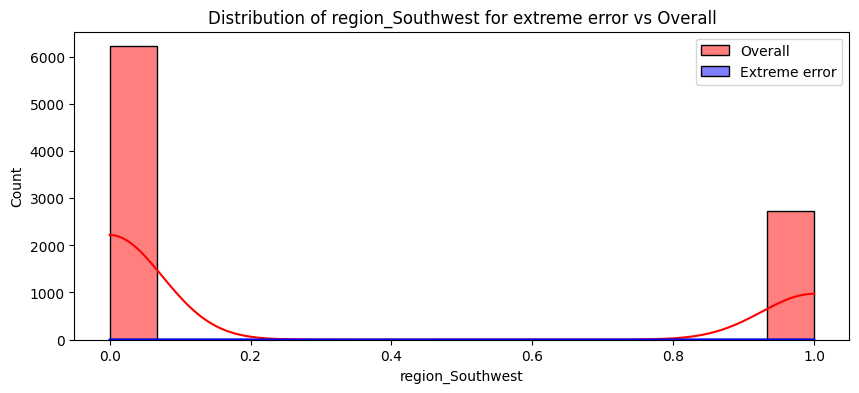

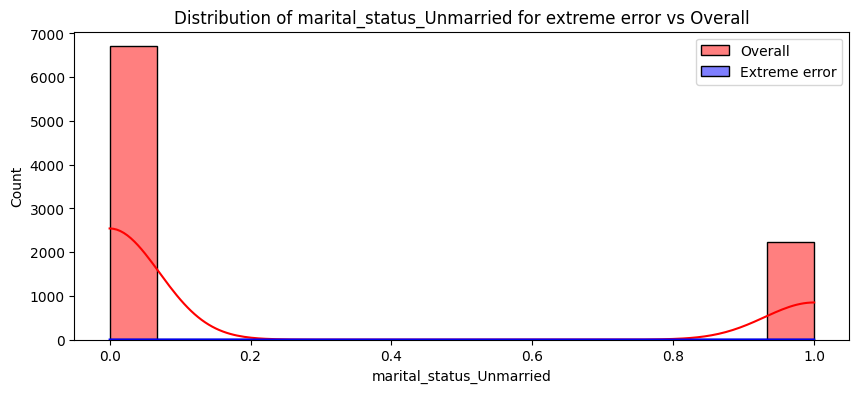

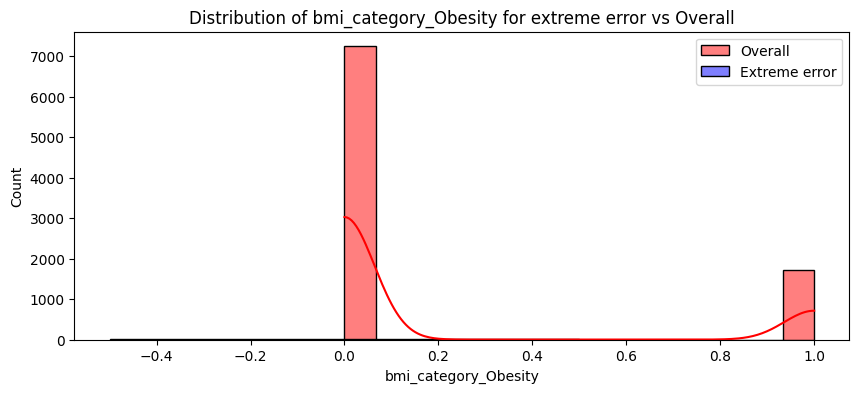

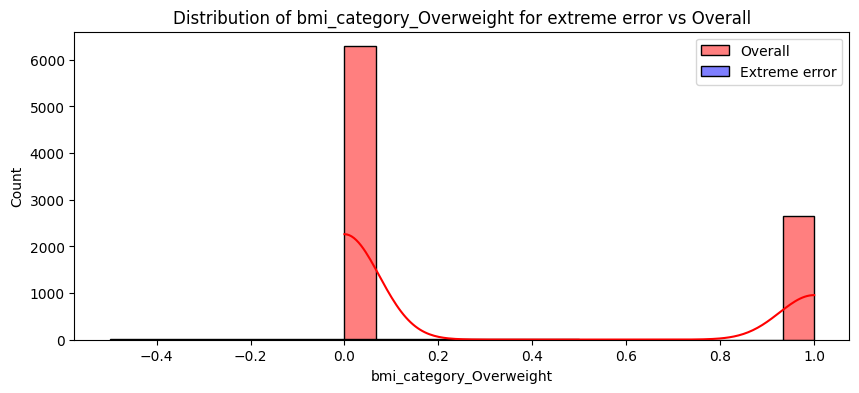

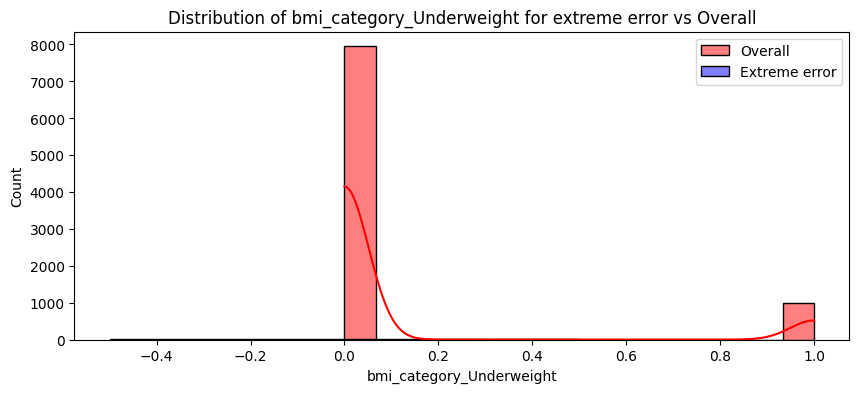

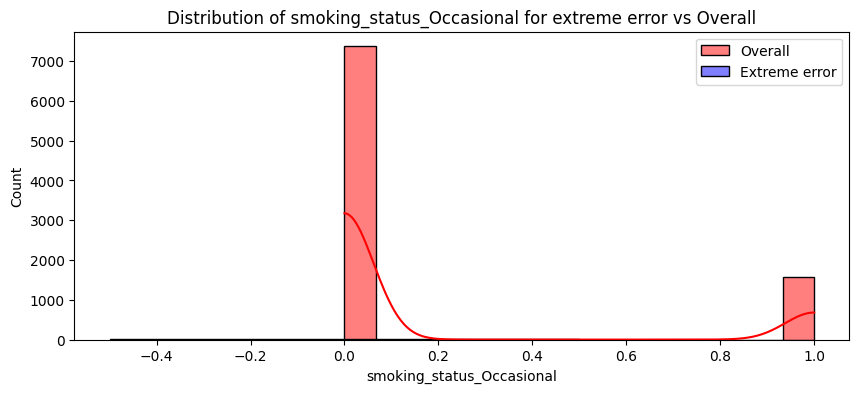

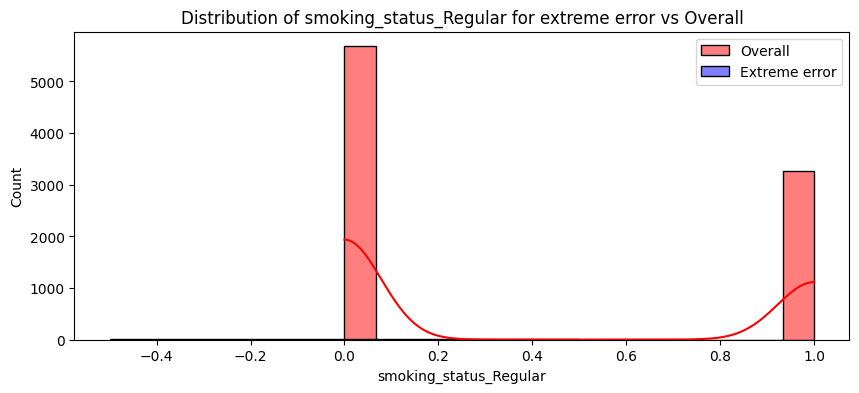

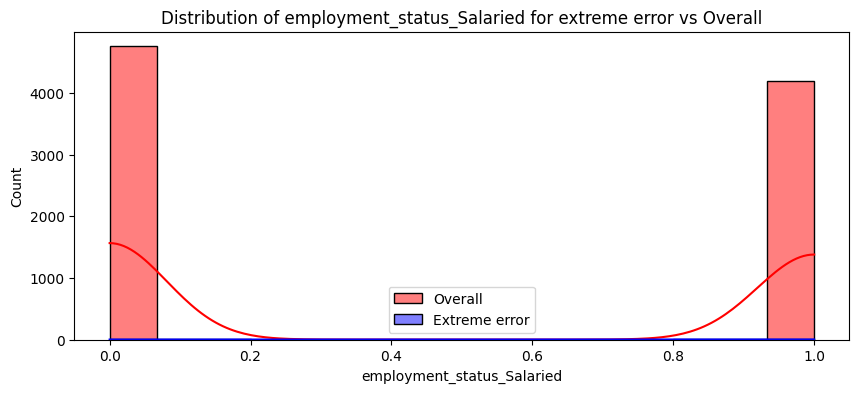

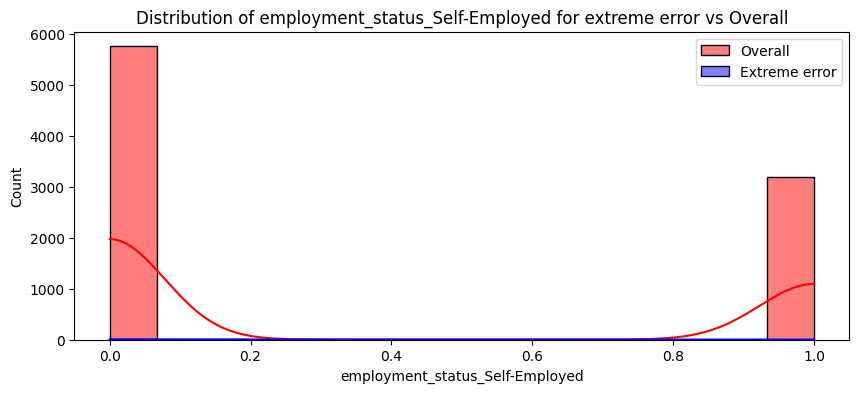

In [71]:
for feature in X_test.columns:
  plt.figure(figsize=(10, 4))
  sns.histplot(X_test[feature], color='red', label="Overall", kde=True)
  sns.histplot(extreme_errors_df[feature], color='blue', label="Extreme error", alpha=0.5, kde=True)
  plt.title(f'Distribution of {feature} for extreme error vs Overall')
  plt.legend()
  plt.show()



> age has some error, error_data is centric towards lower_age_group. We have to scale back to see the accurate age value.



In [72]:
cols_to_scale

['age',
 'number_of_dependants',
 'income_level',
 'income_lakhs',
 'insurance_plan']

In [73]:
extreme_errors_df['income_level']=-1

we have to initialize income_level to perform inverse_scaaling, because we have dropped the column while performing "VIF".

<Axes: xlabel='age', ylabel='Count'>

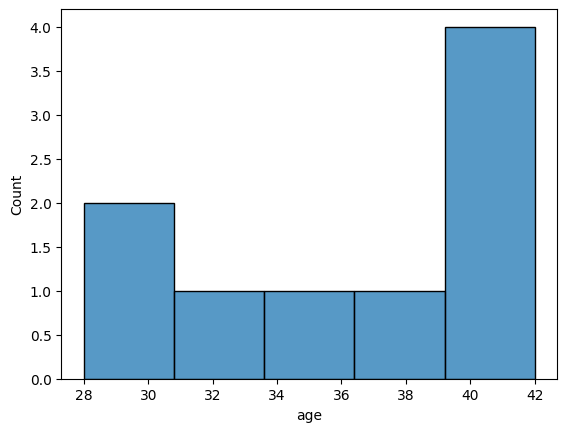

In [74]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
sns.histplot(df_reversed['age'])

In [75]:
df_reversed['age'].quantile(0.97)

np.float64(41.519999999999996)